Import libraries
-------------------------

In [288]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modeling and evaluation:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import pickle

In [289]:
from bs4 import BeautifulSoup

In [290]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Mari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load and Explore the Training Data
---------------------------------------------------

In [291]:
# Load the dataset
df = pd.read_csv('../data/raw/train.csv')

In [292]:
# Preview the train data
df.head()

,review,sentiment
0,I caught this little gem totally by accident b...,positive
1,I can't believe that I let myself into this mo...,negative
2,*spoiler alert!* it just gets to me the nerve ...,negative
3,If there's one thing I've learnt from watching...,negative
4,"I remember when this was in theaters, reviews ...",negative


In [293]:
# Check the shape and info of train data
print("Training data shape:", df.shape)
df.info()

Training data shape: (40000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [294]:
# Check for missing values and duplicate rows
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
review       0
sentiment    0
dtype: int64


In [295]:
# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 272


In [296]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

In [297]:
# Check the shape and info of train data
print("Training data shape:", df.shape)
df.info()

Training data shape: (39728, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 39728 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     39728 non-null  object
 1   sentiment  39728 non-null  object
dtypes: object(2)
memory usage: 931.1+ KB


In [298]:
# check basic statistics
print(df.describe())

                                                   review sentiment
count                                               39728     39728
unique                                              39728         2
top     Dr. Marnie Bannister (Magda Konopka) is a horr...  positive
freq                                                    1     19923


In [299]:
# Check the distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
positive    19923
negative    19805
Name: count, dtype: int64


C:\Users\Mari\AppData\Local\Temp\ipykernel_9044\102453116.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='Set2')


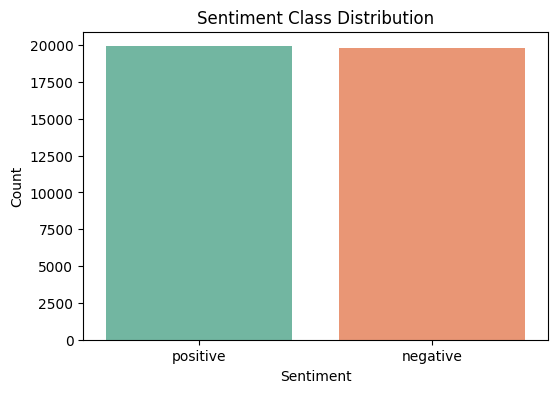

In [300]:
# Plot the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [301]:
# new column 'review_length' which is counting the number of words in each review
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

In [302]:
# summary statistics of review lengths
print("Review Length Statistics:")
print(df['review_length'].describe())

Review Length Statistics:
count    39728.000000
mean       231.502618
std        171.255475
min          4.000000
25%        126.000000
50%        173.000000
75%        282.000000
max       2470.000000
Name: review_length, dtype: float64


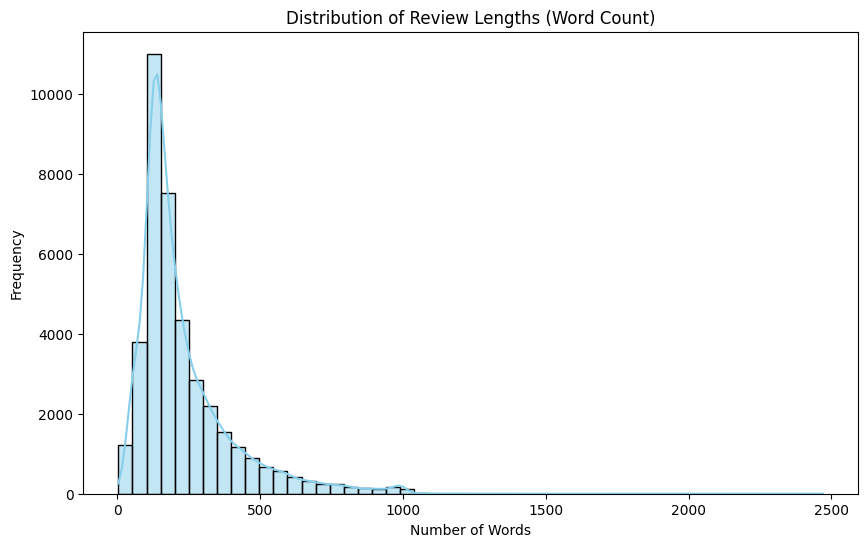

In [303]:
# histogram of the review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Text Preprocessing and Tokenization
----------------------------------------

In [304]:
# Create a set of stopwords
stop_words = set(stopwords.words('english'))

In [305]:
def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text() 


In [306]:
def remove_br(text):
    return re.sub(r'\bbr\b', '', text)

In [307]:
def clean_text(text):
    text = clean_html(text)
    text = remove_br(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<br\s*/?>', ' ', text)
    return text.strip()

In [308]:
def preprocess_text(text):
    # Remove HTML <br> tags
    text = clean_html(text)
    # Remove isolated 'br' tokens 
    text = re.sub(r'\bbr\b', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip() 
    # Tokenize the text
    tokens = word_tokenize(text)
    # Convert tokens to lowercase and keep only alphabetic tokens
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Filter out stopwords
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

In [309]:
# apply the preprocessing function to each review
df['review'] = df['review'].apply(lambda x: ' '.join(preprocess_text(x)))

df['tokens'] = df['review'].apply(preprocess_text)

In [310]:
# original review and its tokens.
print("Original review from the first row:")
print(df['review'].iloc[0])
print("\nTokens from the first review:")
print(df['tokens'].iloc[0])

Original review from the first row:
caught little gem totally accident back revival theatre see two old silly movies theatre packed full warning showed bunch short spoofs get us mood somewhat amusing came within seconds audience hysterics biggest laugh came showed princess laia huge cinnamon buns instead hair head looks camera gives grim smile nods made even funnier got ta see chewabacca played looks like muppet extremely silly stupid could stop laughing dialogue drowned laughter also know star wars pretty well even funnier deliberately poke fun dialogue really works audience definite

Tokens from the first review:
['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch', 'short', 'spoofs', 'get', 'us', 'mood', 'somewhat', 'amusing', 'came', 'within', 'seconds', 'audience', 'hysterics', 'biggest', 'laugh', 'came', 'showed', 'princess', 'laia', 'huge', 'cinnamon', 'b

In [311]:
print(df['review'].iloc[0])

caught little gem totally accident back revival theatre see two old silly movies theatre packed full warning showed bunch short spoofs get us mood somewhat amusing came within seconds audience hysterics biggest laugh came showed princess laia huge cinnamon buns instead hair head looks camera gives grim smile nods made even funnier got ta see chewabacca played looks like muppet extremely silly stupid could stop laughing dialogue drowned laughter also know star wars pretty well even funnier deliberately poke fun dialogue really works audience definite


In [312]:
# display token output from the first review for verification
print("\nTokens from the first review:")
print(df['tokens'].iloc[0])


Tokens from the first review:
['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch', 'short', 'spoofs', 'get', 'us', 'mood', 'somewhat', 'amusing', 'came', 'within', 'seconds', 'audience', 'hysterics', 'biggest', 'laugh', 'came', 'showed', 'princess', 'laia', 'huge', 'cinnamon', 'buns', 'instead', 'hair', 'head', 'looks', 'camera', 'gives', 'grim', 'smile', 'nods', 'made', 'even', 'funnier', 'got', 'ta', 'see', 'chewabacca', 'played', 'looks', 'like', 'muppet', 'extremely', 'silly', 'stupid', 'could', 'stop', 'laughing', 'dialogue', 'drowned', 'laughter', 'also', 'know', 'star', 'wars', 'pretty', 'well', 'even', 'funnier', 'deliberately', 'poke', 'fun', 'dialogue', 'really', 'works', 'audience', 'definite']


Feature Engineering and EDA on Tokens
------------------------------

In [313]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

In [314]:
# Display the 20 most common words
print("\nTop 20 Most Common Words:")
print(word_freq.most_common(20))


Top 20 Most Common Words:
[('movie', 67664), ('film', 61475), ('one', 40804), ('like', 30876), ('good', 22828), ('would', 21071), ('even', 19413), ('time', 18650), ('really', 18349), ('see', 17921), ('story', 17732), ('much', 15026), ('well', 14890), ('could', 14667), ('get', 14432), ('bad', 14207), ('people', 14178), ('great', 14111), ('also', 14087), ('first', 13434)]


C:\Users\Mari\AppData\Local\Temp\ipykernel_9044\1354748637.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette='viridis')


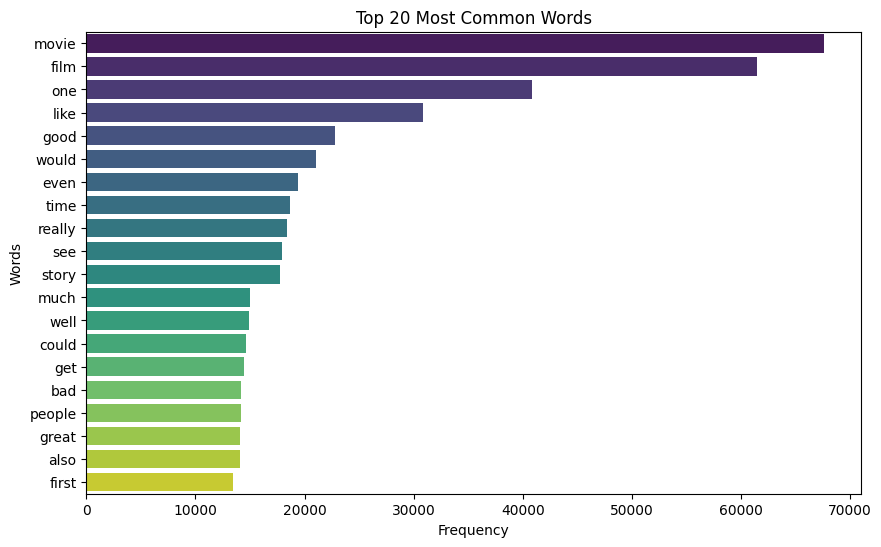

In [315]:
# Plot the 20 most common words
common_words = dict(word_freq.most_common(20))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette='viridis')
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

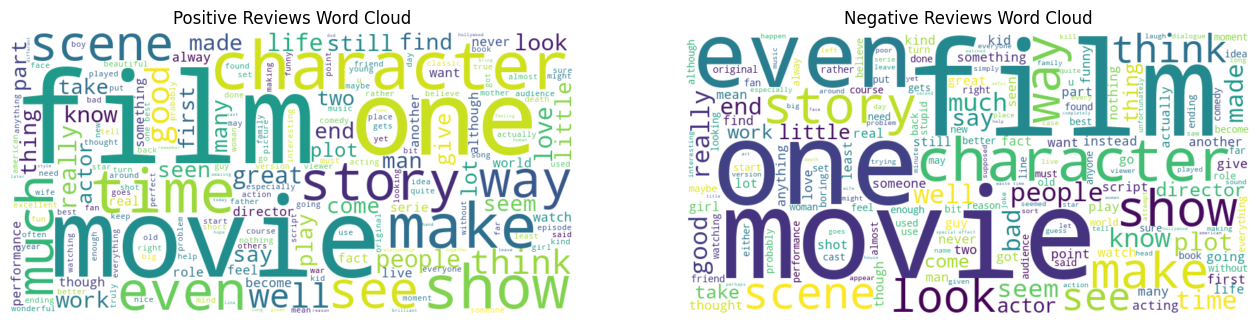

In [316]:
# positive and negative word clouds

positive_text = ' '.join([' '.join(tokens) for tokens in df[df['sentiment'] == 'positive']['tokens']])
negative_text = ' '.join([' '.join(tokens) for tokens in df[df['sentiment'] == 'negative']['tokens']])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

N-gram Analysis
---------------------------

In [317]:
def display_ngrams(corpus, ngram_range=(2,2), top_n=20):
    """
    Extracts and displays the top n-grams from the provided corpus.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    ngrams = vectorizer.fit_transform(corpus)
    sum_words = ngrams.sum(axis=0)
    ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)
    return ngrams_freq[:top_n]

clean_reviews = df['review']

print("\nTop 20 Bigrams:")
bigrams = display_ngrams(clean_reviews, ngram_range=(2, 2))
print(bigrams)

print("\nTop 20 Trigrams:")
trigrams = display_ngrams(clean_reviews, ngram_range=(3, 3))
print(trigrams)


clean_reviews = df['review']

print("\nTop 20 Bigrams:")
bigrams = display_ngrams(clean_reviews, ngram_range=(2, 2))
print(bigrams)

print("\nTop 20 Trigrams:")
trigrams = display_ngrams(clean_reviews, ngram_range=(3, 3))
print(trigrams)


Top 20 Bigrams:
[('special effects', np.int64(1717)), ('looks like', np.int64(1371)), ('good movie', np.int64(1153)), ('waste time', np.int64(1147)), ('look like', np.int64(1052)), ('watch movie', np.int64(1047)), ('new york', np.int64(1012)), ('years ago', np.int64(981)), ('low budget', np.int64(979)), ('movie like', np.int64(911)), ('main character', np.int64(898)), ('pretty good', np.int64(866)), ('movie really', np.int64(864)), ('high school', np.int64(848)), ('movie seen', np.int64(828)), ('bad movie', np.int64(820)), ('year old', np.int64(805)), ('watching movie', np.int64(795)), ('horror movie', np.int64(769)), ('saw movie', np.int64(758))]

Top 20 Trigrams:
[('worst movie seen', np.int64(261)), ('new york city', np.int64(209)), ('world war ii', np.int64(166)), ('worst movies seen', np.int64(166)), ('waste time money', np.int64(147)), ('based true story', np.int64(136)), ('seen long time', np.int64(134)), ('worst film seen', np.int64(117)), ('bad acting bad', np.int64(104)), ('

Stemming vs Lemmatization
---------------------------------

In [318]:
# stemmer and lemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def apply_stemming(tokens):
    return [ps.stem(token) for token in tokens]

def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [319]:
# sample
sample_tokens = df['tokens'].iloc[0]

In [320]:
# apply stemming and lemmatization
stemmed_tokens = apply_stemming(sample_tokens)
lemmatized_tokens = apply_lemmatization(sample_tokens)

In [321]:
# results
print("\nOriginal Tokens:")
print(sample_tokens)
print("\nStemmed Tokens:")
print(stemmed_tokens)
print("\nLemmatized Tokens:")
print(lemmatized_tokens)



Original Tokens:
['caught', 'little', 'gem', 'totally', 'accident', 'back', 'revival', 'theatre', 'see', 'two', 'old', 'silly', 'movies', 'theatre', 'packed', 'full', 'warning', 'showed', 'bunch', 'short', 'spoofs', 'get', 'us', 'mood', 'somewhat', 'amusing', 'came', 'within', 'seconds', 'audience', 'hysterics', 'biggest', 'laugh', 'came', 'showed', 'princess', 'laia', 'huge', 'cinnamon', 'buns', 'instead', 'hair', 'head', 'looks', 'camera', 'gives', 'grim', 'smile', 'nods', 'made', 'even', 'funnier', 'got', 'ta', 'see', 'chewabacca', 'played', 'looks', 'like', 'muppet', 'extremely', 'silly', 'stupid', 'could', 'stop', 'laughing', 'dialogue', 'drowned', 'laughter', 'also', 'know', 'star', 'wars', 'pretty', 'well', 'even', 'funnier', 'deliberately', 'poke', 'fun', 'dialogue', 'really', 'works', 'audience', 'definite']

Stemmed Tokens:
['caught', 'littl', 'gem', 'total', 'accid', 'back', 'reviv', 'theatr', 'see', 'two', 'old', 'silli', 'movi', 'theatr', 'pack', 'full', 'warn', 'show', '

Vectorization
-----------------------------------------------------------

In [322]:
# new column
df['processed_review'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [323]:
# vectorization using CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_count = count_vectorizer.fit_transform(df['processed_review'])

In [324]:
# vectorization using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_review'])

In [325]:
print("CountVectorizer shape:", X_count.shape)
print("TfidfVectorizer shape:", X_tfidf.shape)

CountVectorizer shape: (39728, 2582805)
TfidfVectorizer shape: (39728, 2582805)


Modeling on Train Data
---------------

In [326]:
X = X_tfidf  # Feature
y = df['sentiment']  # Target

In [327]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (31782, 2582805)
Validation set shape: (7946, 2582805)


In [328]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

In [329]:
# train each model and evaluate
model_results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    acc = accuracy_score(y_val, predictions)
    model_results[model_name] = acc
    print(f"{model_name} accuracy: {acc:.4f}")

Logistic Regression accuracy: 0.8841
Multinomial Naive Bayes accuracy: 0.8900
Linear SVM accuracy: 0.9030


In [330]:
# Select the best model based on accuracy
best_model_name = max(model_results, key=model_results.get)
best_accuracy = model_results[best_model_name]
print(f"\nBest Model: {best_model_name} with accuracy {best_accuracy:.4f}")


Best Model: Linear SVM with accuracy 0.9030


In [331]:
# Save the best model and the TF-IDF vectorizer

best_model = models[best_model_name]

with open('../outputs/models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('../outputs/models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Best model and TF-IDF vectorizer saved.")

Best model and TF-IDF vectorizer saved.


Test Data
-------------------------

In [332]:
# Load the test dataset
df_test = pd.read_csv('../data/raw/test.csv')
print("Test data shape:", df_test.shape)
display(df_test.head())

Test data shape: (10000, 2)


,review,sentiment
0,"Yes, MTV there really is a way to market Daria...",negative
1,The story of the bride fair is an amusing and ...,negative
2,"A team varied between Scully and Mulder, two o...",positive
3,This was a popular movie probably because of t...,negative
4,This movie made me so angry!! Here I am thinki...,negative


In [333]:
# Preprocess the test
df_test['tokens'] = df_test['review'].apply(preprocess_text)
df_test['processed_review'] = df_test['tokens'].apply(lambda tokens: ' '.join(tokens))

In [334]:
# Transform test

with open('../outputs/models/tfidf_vectorizer.pkl', 'rb') as f:
    saved_tfidf_vectorizer = pickle.load(f)

X_test = saved_tfidf_vectorizer.transform(df_test['processed_review'])


In [335]:
# Predict sentiments on the test set
with open('../outputs/models/best_model.pkl', 'rb') as f:
    saved_best_model = pickle.load(f)

test_predictions = saved_best_model.predict(X_test)
df_test['predicted_sentiment'] = test_predictions

In [336]:
# Save the test predictions to a CSV file
df_test.to_csv('../outputs/predictions/predictions.csv', index=False)
print("Inference complete. Predictions saved to outputs/predictions/predictions.csv.")

Inference complete. Predictions saved to outputs/predictions/predictions.csv.
